📊 Accuracy:
              ME   RMSE    MAE
Insample  -0.00  0.200  0.155
Outsample  0.14  0.384  0.297


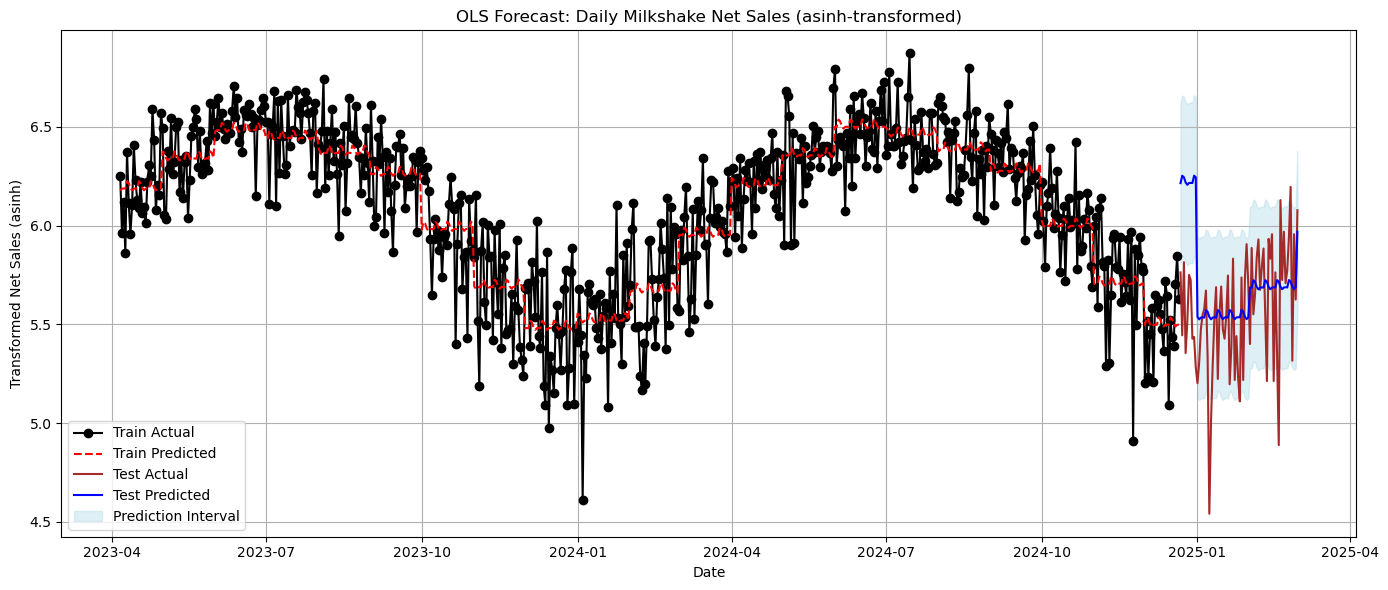

In [1]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Load and filter the milkshake data ---
df = pd.read_csv("ItemSales_2023_2025.csv")

# Convert date column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Filter to keep only milkshake sales
df_milkshake = df[df['Item'].str.contains('Milkshake', case=False, na=False)]

# Aggregate to daily total Net Sales for milkshakes
df_daily = df_milkshake.groupby('Date')['Net Sales'].sum().reset_index()
df_daily = df_daily.rename(columns={'Net Sales': 'Net_Sales'}).dropna()

# --- Feature engineering ---
df_daily['y'] = np.arcsinh(df_daily['Net_Sales'])  # log-like transform for variance stability
df_daily['day'] = df_daily['Date'].dt.day_name()
df_daily['month'] = df_daily['Date'].dt.month_name()
df_daily['x'] = np.arange(len(df_daily))  # time index

# --- Split into training and testing ---
train_ratio = 0.9
train_size = int(len(df_daily) * train_ratio)
train_data = df_daily.iloc[:train_size].copy()
test_data = df_daily.iloc[train_size:].copy()

# --- One-hot encode categorical variables ---
X_train = pd.get_dummies(train_data[['x', 'day', 'month']], drop_first=True)
X_test = pd.get_dummies(test_data[['x', 'day', 'month']], drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)  # Align columns
y_train = train_data['y']

# --- Add intercept and fit OLS model ---
X_train_sm = sm.add_constant(X_train).astype(float)
X_test_sm = sm.add_constant(X_test).astype(float)
y_train = y_train.astype(float)

ols_model = sm.OLS(y_train, X_train_sm).fit()

# --- In-sample predictions ---
train_data['yhat'] = ols_model.predict(X_train_sm)
train_data['e'] = train_data['y'] - train_data['yhat']

# --- Out-of-sample forecast with confidence intervals ---
preds = ols_model.get_prediction(X_test_sm)
summary_frame = preds.summary_frame(alpha=0.05)
test_data['fit'] = summary_frame['mean']
test_data['lwr'] = summary_frame['obs_ci_lower']
test_data['upr'] = summary_frame['obs_ci_upper']

# --- Accuracy metrics ---
def accuracy_metrics(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    me = np.mean(pred - true)
    return pd.Series({'ME': me, 'RMSE': rmse, 'MAE': mae})

acc_in = accuracy_metrics(train_data['y'], train_data['yhat']).round(3)
acc_out = accuracy_metrics(test_data['y'], test_data['fit']).round(3)
print("📊 Accuracy:\n", pd.DataFrame([acc_in, acc_out], index=['Insample', 'Outsample']))

# --- Plot forecast ---
plt.figure(figsize=(14, 6))
plt.plot(train_data['Date'], train_data['y'], label='Train Actual', color='black', marker='o')
plt.plot(train_data['Date'], train_data['yhat'], label='Train Predicted', color='red', linestyle='--')
plt.plot(test_data['Date'], test_data['y'], label='Test Actual', color='brown')
plt.plot(test_data['Date'], test_data['fit'], label='Test Predicted', color='blue')
plt.fill_between(test_data['Date'], test_data['lwr'], test_data['upr'], color='lightblue', alpha=0.4, label='Prediction Interval')
plt.title('OLS Forecast: Daily Milkshake Net Sales (asinh-transformed)')
plt.xlabel('Date')
plt.ylabel('Transformed Net Sales (asinh)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


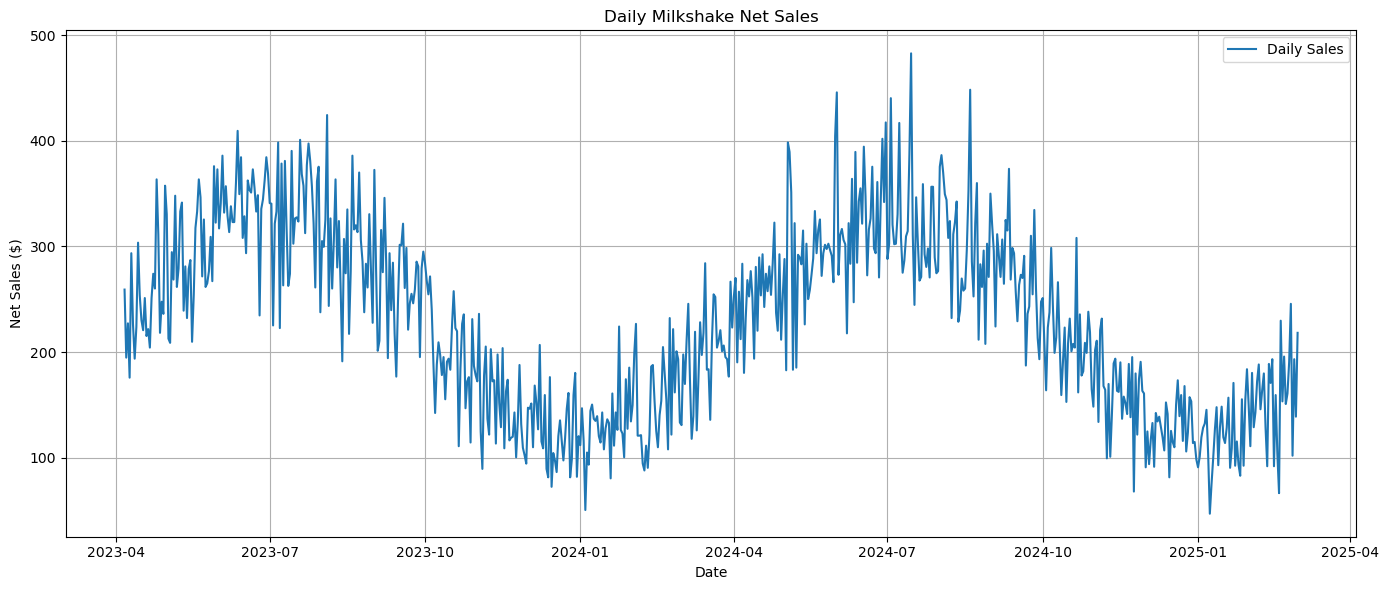

In [2]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_daily, x='Date', y='Net_Sales', label='Daily Sales')
plt.title("Daily Milkshake Net Sales")
plt.xlabel("Date")
plt.ylabel("Net Sales ($)")
plt.grid(True)
plt.tight_layout()
plt.savefig('Figure2_DailyMilkshakeSales.png', dpi=300, bbox_inches='tight')
plt.show()



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Load and filter data ---
df = pd.read_csv("ItemSales_2023_2025.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df_milkshake = df[df['Item'].str.contains('Milkshake', case=False, na=False)]

# --- Aggregate daily Net Sales ---
df_daily = df_milkshake.groupby('Date')['Net Sales'].sum().reset_index()
df_daily = df_daily.rename(columns={'Net Sales': 'Net_Sales'}).dropna()

# --- Apply 7-day rolling average smoothing ---
df_daily['Net_Sales_Smoothed'] = df_daily['Net_Sales'].rolling(window=7, min_periods=1).mean()


# 🔧 Fix: Recompute 'y' after smoothing (ensures it's preserved)
df_daily['y'] = np.arcsinh(df_daily['Net_Sales_Smoothed'])  # log-like transformation

# --- Feature engineering ---
# df_daily['y'] = np.arcsinh(df_daily['Net_Sales_Smoothed'])  # log-like transformation
df_daily['day'] = df_daily['Date'].dt.day_name()
df_daily['month'] = df_daily['Date'].dt.month_name()
df_daily['x'] = np.arange(len(df_daily))

# --- Train/test split ---
train_ratio = 0.9
train_size = int(len(df_daily) * train_ratio)
train_data = df_daily.iloc[:train_size].copy()
test_data = df_daily.iloc[train_size:].copy()

# --- One-hot encoding of categorical features ---
X_train = pd.get_dummies(train_data[['x', 'day', 'month']], drop_first=True)
X_test = pd.get_dummies(test_data[['x', 'day', 'month']], drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)  # Ensure alignment

# --- Add intercept ---
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# --- Force numeric types ---
X_train_sm = X_train_sm.apply(pd.to_numeric, errors='coerce')
X_test_sm = X_test_sm.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(train_data['y'], errors='coerce')

# --- Diagnostics (check types and nulls) ---
print("X_train_sm info:")
print(X_train_sm.info())
print("\nAny NaNs in X_train_sm?", X_train_sm.isnull().any().any())

print("\ny_train info:")
print(y_train.info())
print("Any NaNs in y_train?", y_train.isnull().any())

# --- Drop rows with any missing values in either X or y ---
mask = X_train_sm.notnull().all(axis=1) & y_train.notnull()
X_train_clean = X_train_sm[mask]
y_train_clean = y_train[mask]

print("\n✅ Cleaned training shape:", X_train_clean.shape, y_train_clean.shape)

# --- Fit the OLS model ---
ols_model = sm.OLS(np.asarray(y_train_clean, dtype="float64"), 
                   np.asarray(X_train_clean, dtype="float64")).fit()
print("\n✅ Model fit successful!")

print("📊 OLS Model Summary (7 Day Smoothed):")
print(ols_model.summary())


X_train_sm info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 626 entries, 0 to 625
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   const            626 non-null    float64
 1   x                626 non-null    int32  
 2   day_Monday       626 non-null    bool   
 3   day_Saturday     626 non-null    bool   
 4   day_Sunday       626 non-null    bool   
 5   day_Thursday     626 non-null    bool   
 6   day_Tuesday      626 non-null    bool   
 7   day_Wednesday    626 non-null    bool   
 8   month_August     626 non-null    bool   
 9   month_December   626 non-null    bool   
 10  month_February   626 non-null    bool   
 11  month_January    626 non-null    bool   
 12  month_July       626 non-null    bool   
 13  month_June       626 non-null    bool   
 14  month_March      626 non-null    bool   
 15  month_May        626 non-null    bool   
 16  month_November   626 non-null    bool   
 17 

🧪 Diagnostic check:
✅ test_data_clean shape: (70, 10)
y      0
fit    0
dtype: int64
y      float64
fit    float64
dtype: object

📊 Accuracy:
               ME   RMSE    MAE
Insample  -0.000  0.083  0.065
Outsample  0.123  0.246  0.156


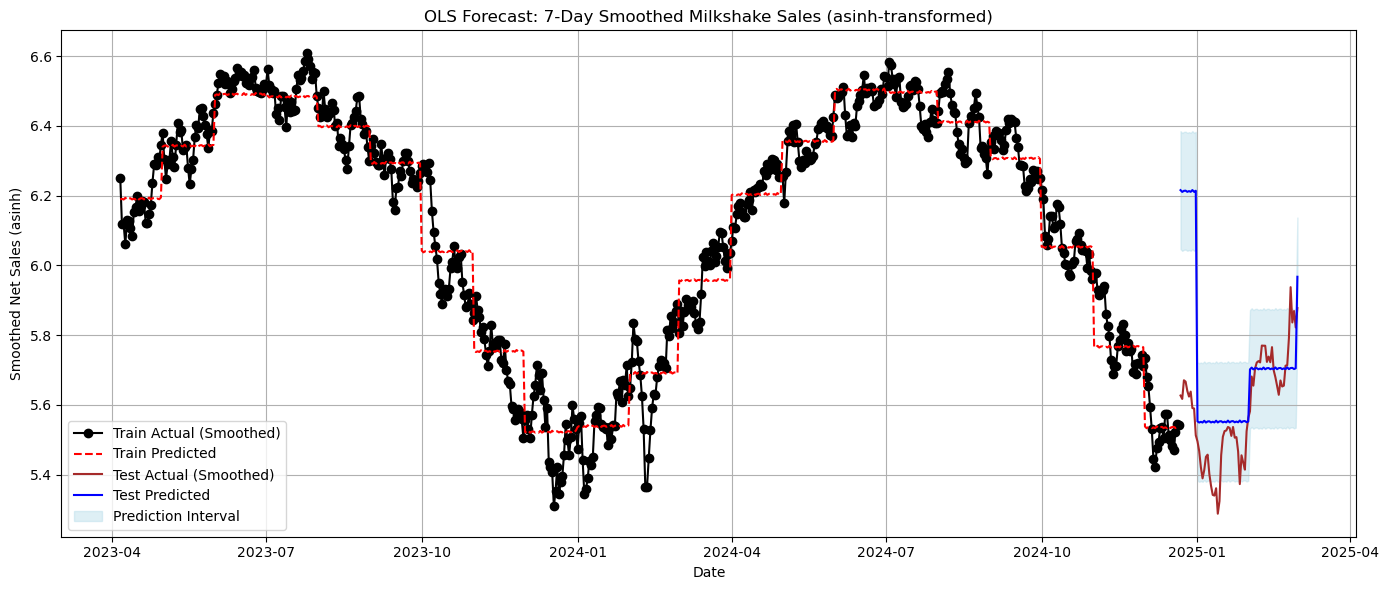

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Reset indices for safety ---
X_test_sm = X_test_sm.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# --- Drop NaNs from predictor set and align test set ---
valid_mask = X_test_sm.notnull().all(axis=1)
X_test_sm_clean = X_test_sm[valid_mask].copy()
test_data_clean = test_data.loc[valid_mask].copy()  # ✅ aligned via mask

# --- Forecast on clean test set ---
X_test_np = np.asarray(X_test_sm_clean, dtype="float64")
preds = ols_model.get_prediction(X_test_np).summary_frame(alpha=0.05)

# Assign predictions to test set
test_data_clean['fit'] = preds['mean']
test_data_clean['lwr'] = preds['obs_ci_lower']
test_data_clean['upr'] = preds['obs_ci_upper']

# --- Add training predictions ---
train_data = train_data.iloc[X_train_clean.index]
X_train_np = np.asarray(X_train_clean, dtype="float64")
train_data['yhat'] = ols_model.predict(X_train_np)

# --- Diagnostics: Check if predictions exist ---
print("🧪 Diagnostic check:")
print("✅ test_data_clean shape:", test_data_clean.shape)
print(test_data_clean[['y', 'fit']].isnull().sum())
print(test_data_clean[['y', 'fit']].dtypes)

# Drop any rows missing forecast or target
test_data_clean = test_data_clean.dropna(subset=['y', 'fit'])

# --- Accuracy metrics ---
def accuracy_metrics(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    me = np.mean(pred - true)
    return pd.Series({'ME': me, 'RMSE': rmse, 'MAE': mae})

acc_in = accuracy_metrics(train_data['y'], train_data['yhat']).round(3)
acc_out = accuracy_metrics(test_data_clean['y'], test_data_clean['fit']).round(3)

print("\n📊 Accuracy:\n", pd.DataFrame([acc_in, acc_out], index=['Insample', 'Outsample']))

# --- Plot the forecast ---
plt.figure(figsize=(14, 6))
plt.plot(train_data['Date'], train_data['y'], label='Train Actual (Smoothed)', color='black', marker='o')
plt.plot(train_data['Date'], train_data['yhat'], label='Train Predicted', color='red', linestyle='--')
plt.plot(test_data_clean['Date'], test_data_clean['y'], label='Test Actual (Smoothed)', color='brown')
plt.plot(test_data_clean['Date'], test_data_clean['fit'], label='Test Predicted', color='blue')
plt.fill_between(test_data_clean['Date'], test_data_clean['lwr'], test_data_clean['upr'], color='lightblue', alpha=0.4, label='Prediction Interval')
plt.title("OLS Forecast: 7-Day Smoothed Milkshake Sales (asinh-transformed)")
plt.xlabel("Date")
plt.ylabel("Smoothed Net Sales (asinh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
print(test_data_clean[['y', 'fit']].isnull().sum())


y      0
fit    0
dtype: int64


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Load and preprocess ---
df = pd.read_csv("ItemSales_2023_2025.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df_milkshake = df[df['Item'].str.contains('Milkshake', case=False, na=False)]
df_daily = df_milkshake.groupby('Date')['Net Sales'].sum().reset_index()
df_daily = df_daily.rename(columns={'Net Sales': 'Net_Sales'}).dropna()

# --- Smoothing and feature creation ---
df_daily['Net_Sales_Smoothed'] = df_daily['Net_Sales'].rolling(window=7, min_periods=1).mean()
df_daily['y'] = np.arcsinh(df_daily['Net_Sales_Smoothed'])
df_daily['day'] = df_daily['Date'].dt.day_name()
df_daily['month'] = df_daily['Date'].dt.month_name()
df_daily['x'] = np.arange(len(df_daily))

# --- Add lag features ---
df_daily['lag_1'] = df_daily['y'].shift(1)
df_daily['lag_7'] = df_daily['y'].shift(7)
df_daily = df_daily.dropna(subset=['lag_1', 'lag_7']).reset_index(drop=True)

# --- Split ---
train_ratio = 0.9
train_size = int(len(df_daily) * train_ratio)
train_data = df_daily.iloc[:train_size].copy()
test_data = df_daily.iloc[train_size:].copy()

# --- One-hot + lags ---
features = ['x', 'day', 'month', 'lag_1', 'lag_7']
X_train = pd.get_dummies(train_data[features], drop_first=True)
X_test = pd.get_dummies(test_data[features], drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# --- Prepare for OLS ---
X_train_sm = sm.add_constant(X_train).apply(pd.to_numeric, errors='coerce')
X_test_sm = sm.add_constant(X_test).apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(train_data['y'], errors='coerce')

mask = X_train_sm.notnull().all(axis=1) & y_train.notnull()
X_train_clean = X_train_sm[mask]
y_train_clean = y_train[mask]

ols_model = sm.OLS(np.asarray(y_train_clean, dtype="float64"),
                   np.asarray(X_train_clean, dtype="float64")).fit()

train_data_cleaned = train_data.iloc[X_train_clean.index].copy()
X_test_sm = X_test_sm.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
train_data_cleaned.reset_index(drop=True, inplace=True)

print("✅ Model with lag features is fitted and ready.")

print("📊 OLS Model Summary (7 Day Smoothed with Lag):")
print(ols_model.summary())


✅ Model with lag features is fitted and ready.
📊 OLS Model Summary (7 Day Smoothed with Lag):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2484.
Date:                Sun, 07 Sep 2025   Prob (F-statistic):               0.00
Time:                        12:48:26   Log-Likelihood:                 1147.3
No. Observations:                 620   AIC:                            -2253.
Df Residuals:                     599   BIC:                            -2160.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------


📊 Accuracy:
               ME   RMSE    MAE
Insample   0.000  0.038  0.030
Outsample  0.021  0.062  0.047


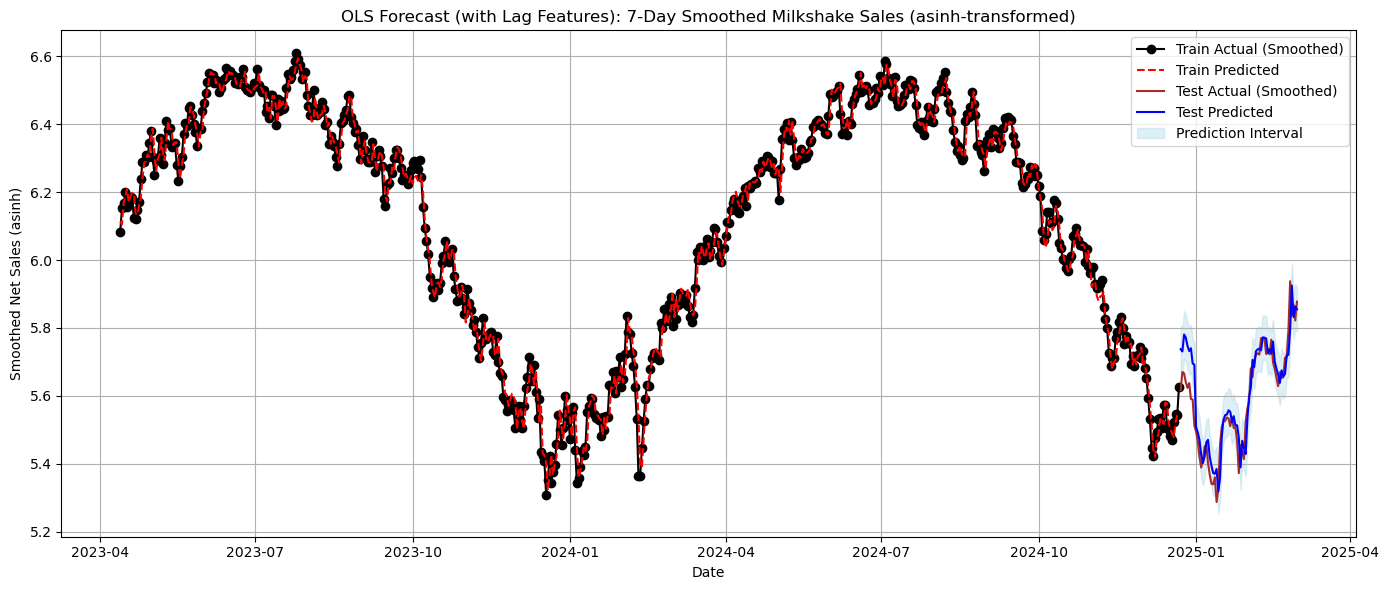

In [7]:
# --- Forecast on clean test set ---
valid_mask = X_test_sm.notnull().all(axis=1)
X_test_sm_clean = X_test_sm[valid_mask]
test_data_clean = test_data[valid_mask].copy()

X_test_np = np.asarray(X_test_sm_clean, dtype="float64")
preds = ols_model.get_prediction(X_test_np).summary_frame(alpha=0.10)

# Assign predictions
test_data_clean['fit'] = preds['mean']
test_data_clean['lwr'] = preds['obs_ci_lower']
test_data_clean['upr'] = preds['obs_ci_upper']

# --- In-sample predictions ---
X_train_np = np.asarray(X_train_clean, dtype="float64")
train_data_cleaned['yhat'] = ols_model.predict(X_train_np)

# --- Drop NaNs for accuracy ---
test_data_clean = test_data_clean.dropna(subset=['y', 'fit'])

# --- Accuracy metrics ---
def accuracy_metrics(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    me = np.mean(pred - true)
    return pd.Series({'ME': me, 'RMSE': rmse, 'MAE': mae})

acc_in = accuracy_metrics(train_data_cleaned['y'], train_data_cleaned['yhat']).round(3)
acc_out = accuracy_metrics(test_data_clean['y'], test_data_clean['fit']).round(3)

# --- Print accuracy ---
print("\n📊 Accuracy:\n", pd.DataFrame([acc_in, acc_out], index=['Insample', 'Outsample']))

# --- Plot forecast ---
plt.figure(figsize=(14, 6))
plt.plot(train_data_cleaned['Date'], train_data_cleaned['y'], label='Train Actual (Smoothed)', color='black', marker='o')
plt.plot(train_data_cleaned['Date'], train_data_cleaned['yhat'], label='Train Predicted', color='red', linestyle='--')
plt.plot(test_data_clean['Date'], test_data_clean['y'], label='Test Actual (Smoothed)', color='brown')
plt.plot(test_data_clean['Date'], test_data_clean['fit'], label='Test Predicted', color='blue')
plt.fill_between(test_data_clean['Date'], test_data_clean['lwr'], test_data_clean['upr'], color='lightblue', alpha=0.4, label='Prediction Interval')
plt.title("OLS Forecast (with Lag Features): 7-Day Smoothed Milkshake Sales (asinh-transformed)")
plt.xlabel("Date")
plt.ylabel("Smoothed Net Sales (asinh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# --- Convert transformed predictions back to dollar scale ---
test_data_clean['actual_dollars'] = np.sinh(test_data_clean['y'])
test_data_clean['predicted_dollars'] = np.sinh(test_data_clean['fit'])
test_data_clean['lower_bound_dollars'] = np.sinh(test_data_clean['lwr'])
test_data_clean['upper_bound_dollars'] = np.sinh(test_data_clean['upr'])


In [9]:
# --- Accuracy in dollars ---
dollar_acc_lagged = accuracy_metrics(
    test_data_clean['actual_dollars'], 
    test_data_clean['predicted_dollars']
).round(2)

print("📊 Lagged OLS Forecast (Dollars):")
print(dollar_acc_lagged)


📊 Lagged OLS Forecast (Dollars):
ME      2.84
RMSE    8.88
MAE     6.54
dtype: float64


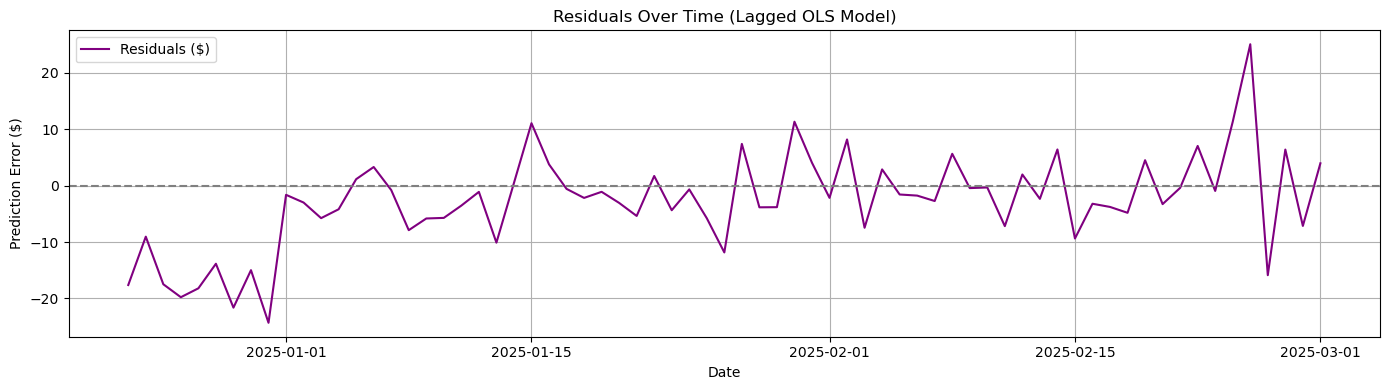

Prediction interval coverage (Lagged model): 76.81%


In [10]:
# --- Residuals over time (dollars) ---
plt.figure(figsize=(14, 4))
plt.plot(
    test_data_clean['Date'], 
    test_data_clean['actual_dollars'] - test_data_clean['predicted_dollars'],
    label='Residuals ($)', color='purple'
)
plt.axhline(0, color='gray', linestyle='--')
plt.title('Residuals Over Time (Lagged OLS Model)')
plt.xlabel('Date')
plt.ylabel('Prediction Error ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Interval coverage ---
coverage_lagged = np.mean(
    (test_data_clean['actual_dollars'] >= test_data_clean['lower_bound_dollars']) &
    (test_data_clean['actual_dollars'] <= test_data_clean['upper_bound_dollars'])
)
print(f"Prediction interval coverage (Lagged model): {coverage_lagged:.2%}")




In [11]:
test_data_clean['range_dollars'] = np.sinh(test_data_clean['upr']) - np.sinh(test_data_clean['lwr'])
print("🪙 Average Prediction Interval Range in Dollars:", round(test_data_clean['range_dollars'].mean(), 2))



🪙 Average Prediction Interval Range in Dollars: 18.25


In [12]:
tolerance = 20  # dollars
within_range = np.mean(np.abs(test_data_clean['actual_dollars'] - test_data_clean['predicted_dollars']) <= tolerance)
print(f"✅ Percent of forecasts within ±${tolerance}: {within_range:.2%}")


✅ Percent of forecasts within ±$20: 95.65%


In [13]:
tolerance = 9 # dollars
within_range = np.mean(np.abs(test_data_clean['actual_dollars'] - test_data_clean['predicted_dollars']) <= tolerance)
print(f"✅ Percent of forecasts within ±${tolerance}: {within_range:.2%}")


✅ Percent of forecasts within ±$9: 75.36%


In [14]:
# Load weather data
df_weather = pd.read_csv("Weather Data.csv")  # Make sure this has a 'Date' column
df_weather['Date'] = pd.to_datetime(df_weather['DATE'])

# Merge with milkshake daily sales
df_daily = pd.merge(df_daily, df_weather, on='Date', how='left')


In [15]:
# --- Create lag features BEFORE dropping NAs ---
df_daily['y_lag1'] = df_daily['y'].shift(1)
df_daily['y_lag7'] = df_daily['y'].shift(7)


# Ensure no missing values in key features before splitting
df_daily = df_daily.dropna(subset=['y', 'y_lag1', 'y_lag7', 'TMIN', 'PRCP'])

# Re-split after merge and lag/feature prep
train_size = int(len(df_daily) * 0.9)
train_data = df_daily.iloc[:train_size].copy()
test_data = df_daily.iloc[train_size:].copy()

# Final feature columns
feature_cols = ['x', 'day', 'month', 'y_lag1', 'y_lag7', 'TMIN', 'PRCP']
X_train = pd.get_dummies(train_data[feature_cols], drop_first=True)
X_test = pd.get_dummies(test_data[feature_cols], drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Add intercepts
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Convert to float64
X_train_np = np.asarray(X_train_sm, dtype="float64")
X_test_np = np.asarray(X_test_sm, dtype="float64")
y_train_np = np.asarray(train_data['y'], dtype="float64")


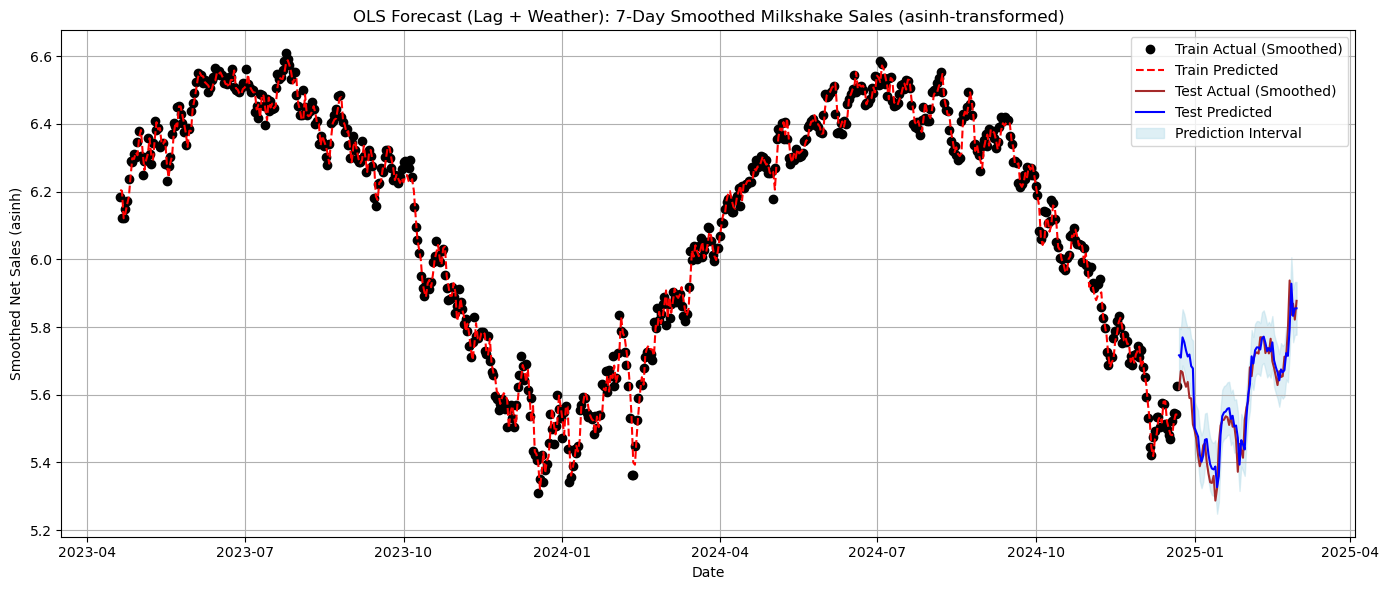

In [16]:
# --- Fit the OLS model with weather and lag features ---
ols_model_weather = sm.OLS(y_train_np, X_train_np).fit()

# --- Predict and get confidence intervals ---
preds_weather = ols_model_weather.get_prediction(X_test_np).summary_frame(alpha=0.05)

# --- Reset indices to align test data safely ---
X_test_sm = X_test_sm.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# --- Filter down to valid prediction rows ---
test_data_clean = test_data.copy()
test_data_clean['fit'] = preds_weather['mean'].values
test_data_clean['lwr'] = preds_weather['obs_ci_lower'].values
test_data_clean['upr'] = preds_weather['obs_ci_upper'].values

# --- Add training predictions ---
train_data['yhat'] = ols_model_weather.predict(X_train_np)

# --- Plot the forecast ---
plt.figure(figsize=(14, 6))
plt.plot(train_data['Date'], train_data['y'], label='Train Actual (Smoothed)', color='black', marker='o', linestyle='')
plt.plot(train_data['Date'], train_data['yhat'], label='Train Predicted', color='red', linestyle='--')
plt.plot(test_data_clean['Date'], test_data_clean['y'], label='Test Actual (Smoothed)', color='brown')
plt.plot(test_data_clean['Date'], test_data_clean['fit'], label='Test Predicted', color='blue')
plt.fill_between(test_data_clean['Date'], test_data_clean['lwr'], test_data_clean['upr'], 
                 color='lightblue', alpha=0.4, label='Prediction Interval')

plt.title("OLS Forecast (Lag + Weather): 7-Day Smoothed Milkshake Sales (asinh-transformed)")
plt.xlabel("Date")
plt.ylabel("Smoothed Net Sales (asinh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
# --- Back-transform predictions to real dollars ---
test_data_clean['actual_dollars'] = np.sinh(test_data_clean['y'])
test_data_clean['predicted_dollars'] = np.sinh(test_data_clean['fit'])
test_data_clean['lower_bound_dollars'] = np.sinh(test_data_clean['lwr'])
test_data_clean['upper_bound_dollars'] = np.sinh(test_data_clean['upr'])


In [18]:
# --- Define and compute accuracy metrics in dollars ---
def accuracy_metrics(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    me = np.mean(pred - true)
    return pd.Series({'ME': me, 'RMSE': rmse, 'MAE': mae})

dollar_acc_weather = accuracy_metrics(
    test_data_clean['actual_dollars'],
    test_data_clean['predicted_dollars']
).round(2)

print("📊 7-Lag + Weather Forecast (Dollars):")
print(dollar_acc_weather)



📊 7-Lag + Weather Forecast (Dollars):
ME      2.67
RMSE    8.21
MAE     6.16
dtype: float64


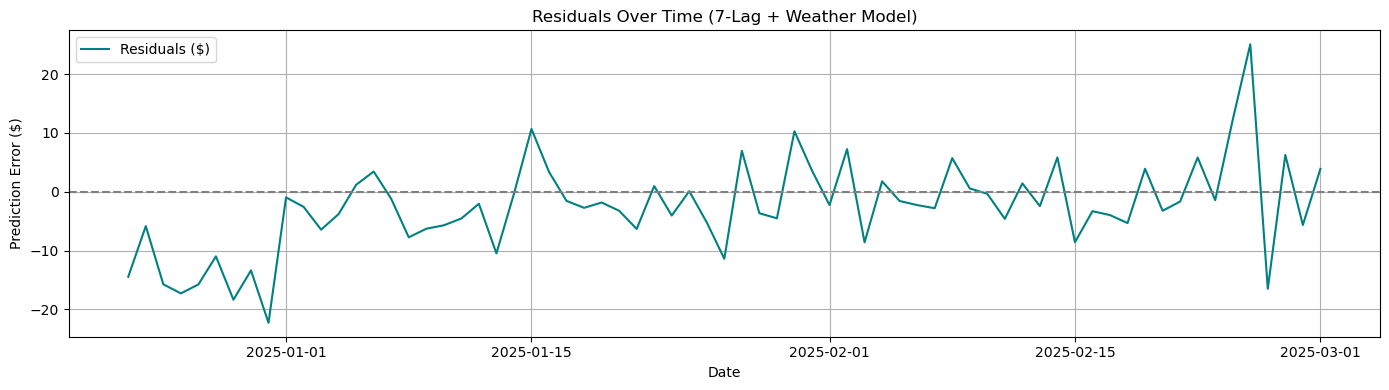

🩵 Prediction interval coverage (7-Lag + Weather): 81.16%


In [19]:
# --- Plot residuals over time ---
plt.figure(figsize=(14, 4))
plt.plot(
    test_data_clean['Date'],
    test_data_clean['actual_dollars'] - test_data_clean['predicted_dollars'],
    color='teal', label='Residuals ($)'
)
plt.axhline(0, linestyle='--', color='gray')
plt.title("Residuals Over Time (7-Lag + Weather Model)")
plt.ylabel("Prediction Error ($)")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Compute prediction interval coverage ---
coverage = np.mean(
    (test_data_clean['actual_dollars'] >= test_data_clean['lower_bound_dollars']) &
    (test_data_clean['actual_dollars'] <= test_data_clean['upper_bound_dollars'])
)
print(f"🩵 Prediction interval coverage (7-Lag + Weather): {coverage:.2%}")



In [20]:
# --- Calculate percent of forecasts within ±$9 ---
tolerance = 9
within_9 = np.mean(
    np.abs(test_data_clean['actual_dollars'] - test_data_clean['predicted_dollars']) <= tolerance
)
print(f"✅ Percent of forecasts within ±${tolerance}: {within_9:.2%}")


✅ Percent of forecasts within ±$9: 78.26%


In [21]:
# --- Calculate percent of forecasts within ±$20 ---
tolerance = 20
within_9 = np.mean(
    np.abs(test_data_clean['actual_dollars'] - test_data_clean['predicted_dollars']) <= tolerance
)
print(f"✅ Percent of forecasts within ±${tolerance}: {within_9:.2%}")


✅ Percent of forecasts within ±$20: 97.10%


C:\Users\nbcha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nbcha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nbcha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


📊 ARIMA(7,1,0) Forecast Accuracy:
ME        NaN
RMSE    39.36
MAE     34.61
dtype: float64


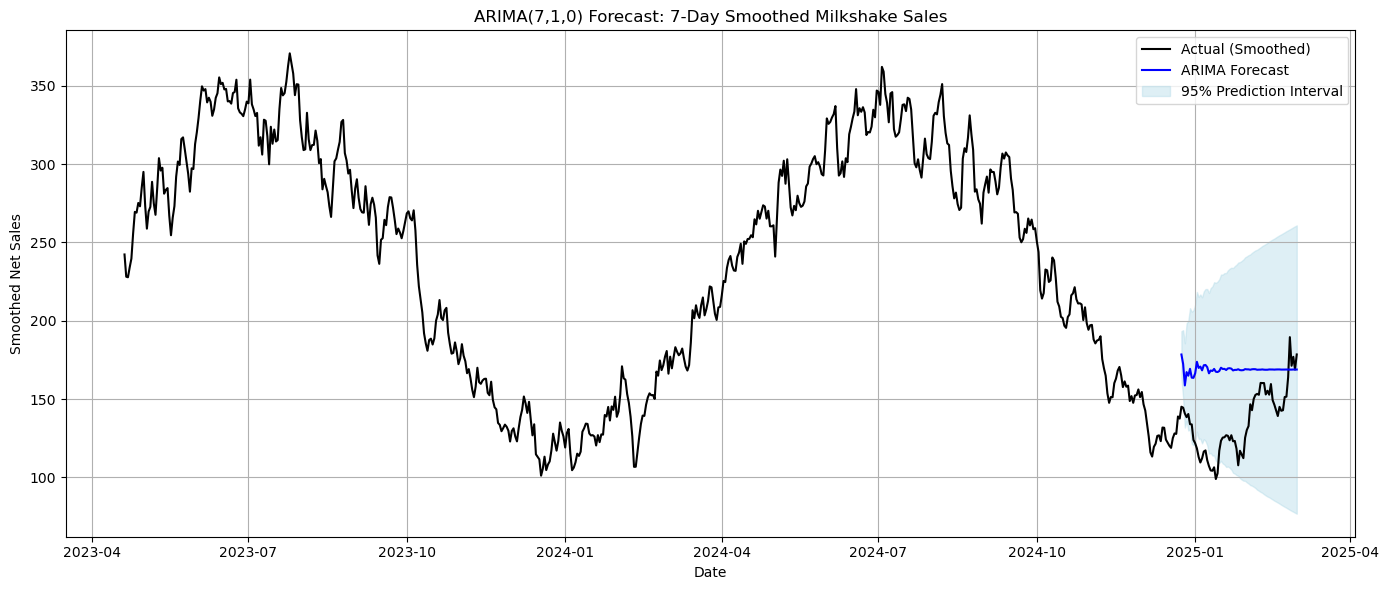

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Ensure date is index and data is clean ---
df_arima = df_daily[['Date', 'Net_Sales_Smoothed']].dropna().copy()
df_arima.set_index('Date', inplace=True)

# --- Fit ARIMA model (start with ARIMA(7,1,0)) ---
arima_model = ARIMA(df_arima['Net_Sales_Smoothed'], order=(7, 1, 0))
arima_result = arima_model.fit()

# --- Forecast next 10% of the data ---
n_forecast = int(len(df_arima) * 0.1)
forecast_result = arima_result.get_forecast(steps=n_forecast)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# --- Prepare actual values for comparison ---
forecast_index = df_arima.index[-n_forecast:]
actual = df_arima.loc[forecast_index, 'Net_Sales_Smoothed']

# --- Accuracy metrics ---
rmse = np.sqrt(mean_squared_error(actual, forecast_mean))
mae = mean_absolute_error(actual, forecast_mean)
me = np.mean(forecast_mean - actual)
accuracy = pd.Series({'ME': me, 'RMSE': rmse, 'MAE': mae}).round(2)
print("📊 ARIMA(7,1,0) Forecast Accuracy:")
print(accuracy)

# --- Forecast plot ---
plt.figure(figsize=(14, 6))
plt.plot(df_arima.index, df_arima['Net_Sales_Smoothed'], label='Actual (Smoothed)', color='black')
plt.plot(forecast_index, forecast_mean, label='ARIMA Forecast', color='blue')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color='lightblue', alpha=0.4, label='95% Prediction Interval')
plt.title("ARIMA(7,1,0) Forecast: 7-Day Smoothed Milkshake Sales")
plt.xlabel("Date")
plt.ylabel("Smoothed Net Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
# --- Back-transform to dollars ---
actual_dollars = np.sinh(actual)
forecast_dollars = np.sinh(forecast_mean)

# --- Compute percentage within ±$9 ---
tolerance = 20
within_tolerance = np.mean(np.abs(forecast_dollars - actual_dollars) <= tolerance)

print(f"✅ Percent of ARIMA forecasts within ±${tolerance}: {within_tolerance:.2%}")


✅ Percent of ARIMA forecasts within ±$20: 0.00%


C:\Users\nbcha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nbcha\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


📊 SARIMAX Forecast Accuracy:
ME      -0.17
RMSE    20.28
MAE     16.79
dtype: float64


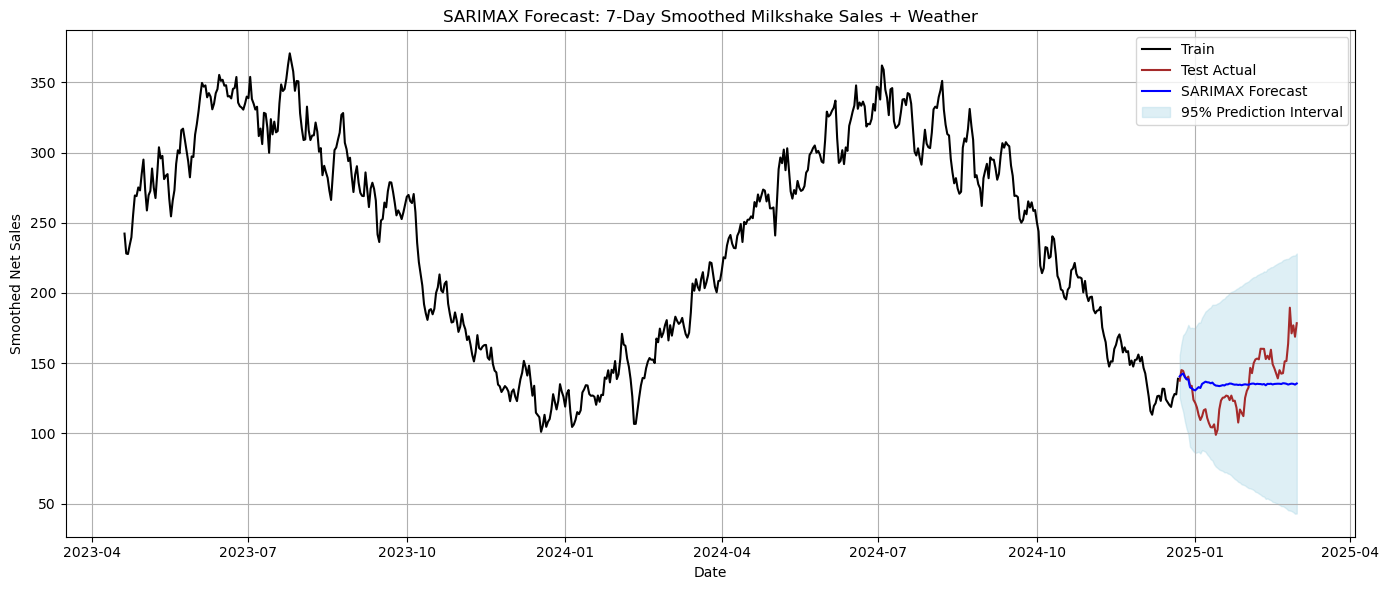

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- Prepare data ---
df_sarimax = df_daily[['Date', 'Net_Sales_Smoothed', 'TMIN', 'PRCP']].dropna().copy()
df_sarimax.set_index('Date', inplace=True)

# --- Train/test split ---
train_size = int(len(df_sarimax) * 0.9)
train = df_sarimax.iloc[:train_size]
test = df_sarimax.iloc[train_size:]

# --- Fit SARIMAX model ---
sarimax_model = SARIMAX(
    train['Net_Sales_Smoothed'],
    exog=train[['TMIN', 'PRCP']],
    order=(7, 1, 0),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_result = sarimax_model.fit(disp=False)

# --- Forecast on test set ---
forecast_result = sarimax_result.get_forecast(
    steps=len(test),
    exog=test[['TMIN', 'PRCP']]
)
forecast_mean = forecast_result.predicted_mean
forecast_ci = forecast_result.conf_int()

# --- Accuracy metrics ---
actual = test['Net_Sales_Smoothed']
rmse = np.sqrt(mean_squared_error(actual, forecast_mean))
mae = mean_absolute_error(actual, forecast_mean)
me = np.mean(forecast_mean - actual)
print("📊 SARIMAX Forecast Accuracy:")
print(pd.Series({'ME': me, 'RMSE': rmse, 'MAE': mae}).round(2))

# --- Plot forecast ---
plt.figure(figsize=(14, 6))
plt.plot(train.index, train['Net_Sales_Smoothed'], label='Train', color='black')
plt.plot(test.index, actual, label='Test Actual', color='brown')
plt.plot(test.index, forecast_mean, label='SARIMAX Forecast', color='blue')
plt.fill_between(test.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1],
                 color='lightblue', alpha=0.4, label='95% Prediction Interval')
plt.title("SARIMAX Forecast: 7-Day Smoothed Milkshake Sales + Weather")
plt.xlabel("Date")
plt.ylabel("Smoothed Net Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
# Get the forecasted values (likely 39 points instead of 40)
n_forecast_actual = len(forecast_result.predicted_mean)

# Use the last 39 dates from df_daily
forecast_index = df_daily.index[-n_forecast_actual:]

# Create the test DataFrame correctly aligned
test = pd.DataFrame({
    'Date': forecast_index,
    'predicted': forecast_result.predicted_mean.values,
    'lwr': forecast_result.conf_int().iloc[:, 0].values,
    'upr': forecast_result.conf_int().iloc[:, 1].values
}).set_index('Date')

# Pull actuals from df_daily
test['actual'] = df_daily.loc[forecast_index, 'Net_Sales_Smoothed']

# Back-transform to dollars
test['actual_dollars'] = np.sinh(test['actual'])
test['predicted_dollars'] = np.sinh(test['predicted'])
test['lower_bound_dollars'] = np.sinh(test['lwr'])
test['upper_bound_dollars'] = np.sinh(test['upr'])

# Drop NaNs
test_clean = test.dropna(subset=['actual_dollars', 'predicted_dollars'])

# Accuracy
def accuracy_metrics(true, pred):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    me = np.mean(pred - true)
    return pd.Series({'ME': me, 'RMSE': rmse, 'MAE': mae})

dollar_acc = accuracy_metrics(test_clean['actual_dollars'], test_clean['predicted_dollars']).round(2)
print("📊 SARIMAX Accuracy in Dollars:")
print(dollar_acc)

# Within $9
tolerance = 20
within_9 = np.mean(np.abs(test_clean['actual_dollars'] - test_clean['predicted_dollars']) <= tolerance)
print(f"✅ Percent within ±${tolerance}: {within_9:.2%}")


📊 SARIMAX Accuracy in Dollars:
ME     -1.448088e+80
RMSE    1.202849e+81
MAE     1.448088e+80
dtype: float64
✅ Percent within ±$20: 0.00%
